In [1]:
# first draw tokens distribution:

import os
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import pickle

def update_x(x):
    if x == ' ':
        return '\\s'
    elif x == '\n':
        return '\\n'
    return x


meta_path = 'nanoGPT/data/shakespeare_char/meta.pkl'
load_meta = os.path.exists(meta_path)
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)
    # TODO want to make this more general to arbitrary encoder/decoder schemes
stoi, itos = meta['stoi'], meta['itos']
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

data_dir = 'nanoGPT/data/shakespeare_char'
data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')

counter = Counter(data)
counts = np.array(sorted(counter.values(), reverse=True))

decoded_tokens = list(counter.items())
decoded_tokens = sorted(decoded_tokens, key=lambda x: x[1], reverse=True)
decoded_tokens = [int(x[0]) for x in decoded_tokens]
decoded_tokens = list(decode(decoded_tokens))

decoded_tokens = [update_x(x) for x in decoded_tokens]

sorted_tokens = [token for token, _ in counter.most_common()]

/tmp/ipykernel_667/1072179820.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = {name: torch.load(path)['model']['lm_head.weight'] for name, path in state_dict_

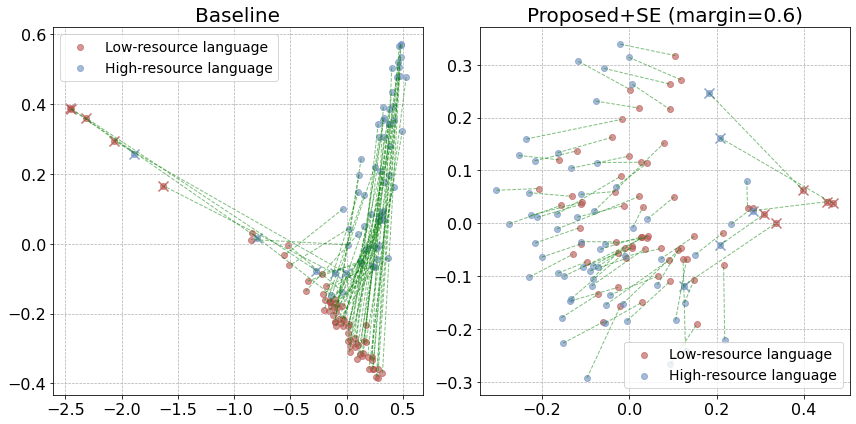

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

state_dict_paths = {
    'baseline': 'nanoGPT/out/baseline/ckpt.pt',
    'margin_1': 'nanoGPT/out/proposed_margin_1/ckpt.pt',
    'SE_1': 'nanoGPT/out/proposed_margin_1.0_separated_embeddings/ckpt.pt',
    'SE_0.6': 'nanoGPT/out/proposed_margin_0.6_separated_embeddings/ckpt.pt',
#     'SE_alpha_0.0625': 'nanoGPT/out/proposed_margin_by_weight_type_3_alpha_0.0625_SE/ckpt.pt',

}

weights = {name: torch.load(path)['model']['lm_head.weight'] for name, path in state_dict_paths.items()}

pca = PCA(n_components=2)

special_token_ids = [int(x) for x in sorted_tokens[-5:]]
special_token_pairs = [i + 65 for i in special_token_ids]

name2embeddings = {name: pca.fit_transform(ww) for name, ww in weights.items()}

# Find global min and max for setting the same axis limits
x_min = min([x[:, 0].min() for x in name2embeddings.values()])
x_max = max([x[:, 0].max() for x in name2embeddings.values()])
y_min = min([x[:, 1].min() for x in name2embeddings.values()])
y_max = max([x[:, 1].max() for x in name2embeddings.values()])

xy_max = max(x_max, y_max)
xy_min = min(x_min, y_min)

# Add a 10% padding to the limits
x_range = xy_max - xy_min
y_range = xy_max - xy_min

x_min = xy_min - 0.1 * x_range
x_max = xy_max + 0.1 * x_range
y_min = xy_min - 0.1 * y_range
y_max = xy_max + 0.1 * y_range

# Create two scatter plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

name2titles = {
    'baseline': 'Baseline',
    'margin_1': 'Proposed (margin=1)',
    'SE_1': 'Proposed+SE (margin=1)',
    'SE_0.6': 'Proposed+SE (margin=0.6)',
#     'SE_alpha_0.0625': f'Proposed+SE (alpha=0.0625)',
}

for i, name in enumerate(['baseline', 'SE_0.6']):
    embeddings = name2embeddings[name]
    title = name2titles[name]
    ax = axes[i]
#     # Connect corresponding points (i with i+65) in the plot
    for i in range(65):
#         i_character = decode([i])
#         if i_character.isalpha():
#             if i_character.isupper():
#                 neighbor_i = encode(i_character.lower())[0]
#             else:
#                 neighbor_i = encode(i_character.upper())[0]
#             ax.plot([embeddings[i, 0], embeddings[neighbor_i, 0]], [embeddings[i, 1], embeddings[neighbor_i, 1]],
#                 'b--', linewidth=1, alpha=0.2)
#             ax.plot([embeddings[i+65, 0], embeddings[neighbor_i+65, 0]], [embeddings[i+65, 1], embeddings[neighbor_i+65, 1]],
#                 'r--', linewidth=1, alpha=0.2)
        
        ax.plot([embeddings[i, 0], embeddings[i + 65, 0]], [embeddings[i, 1], embeddings[i + 65, 1]],
                'g--', linewidth=1, alpha=0.5)

    # Highlight the special tokens with a cross ('x') marker
    ax.scatter(embeddings[special_token_ids, 0], embeddings[special_token_ids, 1],
               c='#6C8EBF', marker='x', s=100, alpha=0.8)
    ax.scatter(embeddings[special_token_pairs, 0], embeddings[special_token_pairs, 1],
               c='#B85450', marker='x', s=100, alpha=0.8)


    
    # Scatter the second 65 rows (low-resource) in red
    ax.scatter(embeddings[65:, 0], embeddings[65:, 1], c='#B85450', label='Low-resource language', alpha=0.6)
    # Scatter the first 65 rows (high-resource) in blue
    ax.scatter(embeddings[:65, 0], embeddings[:65, 1], c='#6C8EBF', label='High-resource language', alpha=0.6)

    
    
    # Set plot title, limits, and legend
    ax.set_title(title, fontsize=20)
#     ax.set_xlim(x_min, x_max)
#     ax.set_ylim(y_min, y_max)
    ax.legend(fontsize=14)

    ax.grid(True, which='both', linestyle='--', linewidth=0.7) # , axis='y')
    # Adjust fontsize using tick_params for both x and y ticks
    ax.tick_params(axis='x', labelsize=16)  # Change only x-axis tick label fontsize
    ax.tick_params(axis='y', labelsize=16)  # Change only y-axis tick label fontsize

    
# Show the plots
plt.tight_layout()

plt.savefig("assets/PCA_embeddings.pdf", format="pdf")

plt.show()


In [3]:
sorted_tokens = np.arange(65) # np.array(sorted_tokens) # 
sorted_tokens = np.hstack([sorted_tokens, sorted_tokens + 65])

In [4]:
mask = np.zeros((65*2,65*2), dtype=int)

# non-alphabet characters
counter = 1
i, j = 0, 65
start, end = 0, 13
mask[i+start:i+end, i+start:i+end] = counter  # non-alhabet characters (HR)
# counter += 1
mask[j+start:j+end, j+start:j+end] = counter  # non-alhabet characters (LR)
# counter += 1
mask[i+start:i+end, j+start:j+end] = mask[j+start:j+end, i+start:i+end] = counter  # non-alhabet characters (HR-LR)
counter += 1

start, end = 13, 13+26
mask[i+start:i+end, i+start:i+end] = counter  # upper (HR)
# counter += 1
mask[j+start:j+end, j+start:j+end] = counter  # upper (LR)
# counter += 1
mask[i+start:i+end, j+start:j+end] = mask[j+start:j+end, i+start:i+end] = counter  # upper (HR-LR)
counter += 1

start, end = 13+26, 13+26*2
mask[i+start:i+end, i+start:i+end] = counter  # lower (HR)
# counter += 1
mask[j+start:j+end, j+start:j+end] = counter  # lower (LR)
# counter += 1
mask[i+start:i+end, j+start:j+end] = mask[j+start:j+end, i+start:i+end] = counter  # lower (HR-LR)
counter += 1


mask[np.arange(65*2), np.arange(65*2)] = counter # main diagonal
counter += 1
mask[np.arange(65), np.arange(65, 65*2)] = mask[np.arange(65, 65*2), np.arange(65)] = counter # "translation" diagonal
counter += 1

mask[np.arange(i+13, i+13+26), np.arange(i+13+26, i+13+26*2)] = counter # main diagonal
mask[np.arange(i+13+26, i+13+26*2), np.arange(i+13, i+13+26)] = counter # main diagonal
# counter += 1

mask[np.arange(j+13, j+13+26), np.arange(j+13+26, j+13+26*2)] = counter # main diagonal
mask[np.arange(j+13+26, j+13+26*2), np.arange(j+13, j+13+26)] = counter # main diagonal
counter += 1

mask[np.arange(i+13, i+13+26), np.arange(j+13+26, j+13+26*2)] = counter # main diagonal
mask[np.arange(i+13+26, i+13+26*2), np.arange(j+13, j+13+26)] = counter # main diagonal
mask[np.arange(j+13, j+13+26), np.arange(i+13+26, i+13+26*2)] = counter # main diagonal
mask[np.arange(j+13+26, j+13+26*2), np.arange(i+13, i+13+26)] = counter # main diagonal
counter += 1

In [5]:

import matplotlib.colors as mcolors

# Modify the colormap to include white for the background (0) index
cmap = plt.cm.get_cmap('tab20c', np.max(mask) + 1)  # We need a number of unique colors equal to the max value in the mask
cmap_list = [cmap(i) for i in range(cmap.N)]
cmap_list[0] = (1.0, 1.0, 1.0, 1.0)  # Set the first color (index 0) to white
cmap_list[-4] = (0, 0, 0, 1.0)
cmap_list[-3] = (1, 0, 0, 1.0)
cmap_list[-2] = (0, 0, 1, 1.0)
cmap_list[-1] = (1, 0, 1, 1.0)

# Create the new colormap with the modified list
custom_cmap = mcolors.ListedColormap(cmap_list)

import matplotlib.patches as mpatches

# Define the color patches for the legend using the same colors as the indices in the mask
idx2label = [
    'background',
    'NA',
    'UC',
    'LC',
    'ID',
    'T',
    'C',
    'T+C'
]
patches = []
for idx in range(1, np.max(mask) + 1):
    color = cmap_list[idx]
    patch = mpatches.Patch(color=color, label=idx2label[idx])
    patches.append(patch)

/tmp/ipykernel_667/3768881183.py:11: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  w_similarity = F.cosine_similarity(embeddings.unsqueeze(-1), embeddings.unsqueeze(-1).T, dim=1)


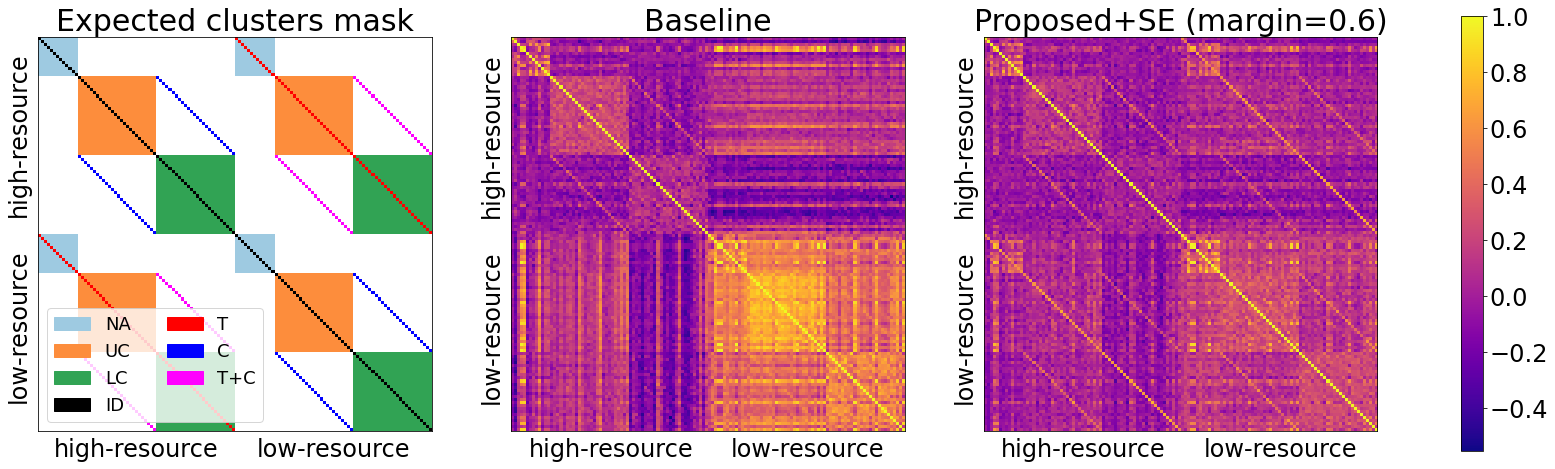

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# Step 1: Calculate the global min and max for w_similarity across all models
global_min = float('inf')
global_max = float('-inf')

for name in weights:
    embeddings = weights[name]
    w_similarity = F.cosine_similarity(embeddings.unsqueeze(-1), embeddings.unsqueeze(-1).T, dim=1)
    global_min = min(global_min, w_similarity.min().item())
    global_max = max(global_max, w_similarity.max().item())

# Prepare the plot with larger size
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

# Define custom tick points
n = 130
half_n = n // 2



ax = axes[0] # axes[i // 2, i % 2]

nrows, ncols = mask.shape
x = np.arange(ncols + 1)
y = np.arange(nrows, -1, -1)

# Plot the mask using pcolormesh
cax = ax.pcolormesh(x, y, mask, cmap=custom_cmap, shading='flat')

ax.set_aspect('equal')
# Add the legend with patches, outside the plot on the right
ax.legend(handles=patches, loc='lower left', fontsize=18, ncol=2)

ax.set_title("Expected clusters mask", fontsize=30)

# Custom x and y ticks
ax.set_xticks([half_n / 2, (3 * half_n) / 2])
ax.set_xticklabels(['high-resource', 'low-resource'], fontsize=24)
ax.set_yticks([(15 * half_n) / 8, 7 * half_n / 8])
ax.set_yticklabels(['high-resource', 'low-resource'], rotation=90, fontsize=24)
    
ax.tick_params(left=False, bottom=False)



# Iterate over the weight matrices and plot the similarities
for i, name in enumerate(['baseline', 'SE_0.6']): # enumerate(weights):
# for i, name in enumerate(['SE_0.6', 'SE_alpha_0.0625']):
    embeddings = weights[name]
    w_similarity = F.cosine_similarity(embeddings.unsqueeze(-1), embeddings.unsqueeze(-1).T, dim=1)

    # Sort the similarity matrix according to sorted_tokens
    w_similarity_sorted = w_similarity.numpy()[np.ix_(sorted_tokens, sorted_tokens)]
    
    # Get the axis and title
    ax = axes[i+1] # axes[i // 2, i % 2]
    title = name2titles[name]
    
    # Display the image with shared vmin and vmax across subplots (shared color scale)
    img = ax.imshow(w_similarity_sorted, cmap='plasma', aspect='equal', vmin=global_min, vmax=global_max)
    
    # Set plot title
    ax.set_title(title, fontsize=30)
    
    # Custom x and y ticks
    ax.set_xticks([half_n / 2, (3 * half_n) / 2])
    ax.set_xticklabels(['high-resource', 'low-resource'], fontsize=24)
    ax.set_yticks([half_n / 8, (9 * half_n) / 8])
    ax.set_yticklabels(['high-resource', 'low-resource'], rotation=90, fontsize=24)
    
    # Hide the default ticks
    ax.tick_params(left=False, bottom=False)

# Step 2: Add a single color bar to the right of the figure
cbar = fig.colorbar(img, ax=axes, location='right', shrink=0.8)
cbar.ax.tick_params(labelsize=24)

# Step 3: Ensure subplots are square by adjusting the layout
plt.gca().set_aspect('equal', adjustable='box')
# plt.tight_layout()

# Save and display the plot
plt.savefig("assets/cosine_similarity.pdf", format="pdf", bbox_inches='tight')
plt.show()


In [9]:
def update_x(x):
    if x == ' ':
        return '\\s'
    elif x == '\n':
        return '\\n'
    return x

def get_token(i_s):
    result = []
    for i in i_s:
        if i < 65:
            result.append('b'+update_x(decode([i])))
        else:
            result.append('s'+update_x(decode([i-65])))
    return result

token_index = 65 + 13 + 26
for i, name in enumerate(weights):
    embeddings = weights[name]
    w_similarity = F.cosine_similarity(embeddings.unsqueeze(-1), embeddings.unsqueeze(-1).T, dim=1)
    values, indices = w_similarity[token_index].sort(descending=True)
    print(name, token_index, get_token([token_index]), ':',list(zip(
                get_token(indices.numpy()[:6]),
                values.numpy()[:6].round(2))
            ))

baseline 104 ['sa'] : [('sa', 1.0), ('si', 0.86), ('so', 0.71), ('se', 0.71), ('sr', 0.61), ('su', 0.6)]
margin_1 104 ['sa'] : [('sa', 1.0), ('si', 0.56), ('so', 0.51), ('se', 0.42), ('su', 0.38), ('sA', 0.38)]
SE_1 104 ['sa'] : [('sa', 1.0), ('ba', 0.55), ('si', 0.54), ('so', 0.49), ('se', 0.42), ('sA', 0.39)]
SE_0.6 104 ['sa'] : [('sa', 1.0), ('ba', 0.69), ('si', 0.44), ('sA', 0.43), ('so', 0.41), ('bA', 0.32)]
